### Лабораторная работа 2. 

#### Задание 1. ИМИТАЦИЯ НЕПРЕРЫВНЫХ СЛУЧАЙНЫХ ВЕЛИЧИН (МЕТОД ОБРАТНЫХ ФУНКЦИЙ)

In [79]:
from random import random, uniform
from math import erf, log, exp
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy import simplify
from sympy.abc import x, y
from sympy.calculus.util import continuous_domain
from scipy.stats import norm, chi2


In [80]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
number_of_dots = 1000
gamma = 0.95 # уровень доверия
hypothesis_error_value = 0.05 

#### Линейный конгруэнтный метод

In [81]:
# Линейный конгруэнтный метод 
class CustomGenerator:
    seed = 42
    alpha = 1664525
    c = 1013904223
    m = 2 ** 32
    x_current = seed
    
    @staticmethod
    def random():
        CustomGenerator.x_current = (CustomGenerator.alpha * CustomGenerator.x_current + CustomGenerator.c) % CustomGenerator.m
        return CustomGenerator.x_current / CustomGenerator.m

#### Поиск обратной функции

In [82]:
def find_inverse_function(input_text): 
    global inverse_function
    ex = sympify(input_text)
    distribution_expression = ex
    extra = ex - y
    results = solve(extra, x)
    # print(results)
    
    is_found = False
    for result in results:
        is_continuous = continuous_domain(result, y, S.Reals).is_proper_superset(Interval(0, 1))
        derivative = diff(result, y)
        derivative_positive = solve(derivative > 0, y, domain=S.Reals)
        if derivative_positive and is_continuous:
            print(f"Обратная функция: {result}")
            inverse_function = lambdify(y, result)
            is_found = True
            break

    if not is_found:
        print("обратная функция не найдена")


#### Генерация значений

In [83]:
generator = CustomGenerator()

def generate_func_data(amount):
    global inverse_function
    data=[]
    for i in range(amount):
        y = generator.random()
        data.append(inverse_function(y))
    return data

#### Нахождение матожидайний

In [84]:
def calculate_sample_mean(sample):
    return sum(sample) / len(sample)

def calculate_theoretical_mean(func, limits):
    return integrate(x * func, (x, limits[0], limits[1]))

#### Нахождение дисперсий

In [85]:
def calculate_sample_variance(sample):
    sample_mean = calculate_sample_mean(sample)
    variance = sum((x - sample_mean) ** 2 for x in sample) / len(sample)
    return variance

def calculate_theoretical_variance(func, limits, theoretical_mean):
    integral = integrate(x ** 2 * func, (x, limits[0], limits[1]))
    theoretical_variance = integral - theoretical_mean ** 2
    return theoretical_variance.evalf()

In [86]:
# confidence interval
def get_delta(offset):
    t = norm.ppf(gamma / 2 + 0.5) # квантили
    return t * offset / np.sqrt(number_of_tests) # Margin of Error

def get_offset_delta(test_offset): # build confidence level (хи квадрат)
    alphas = ((1 - gamma) / 2, (1 + gamma) / 2)  #границы для вычисления квантили хиквадрат распределения
    chis = (chi2.isf(alphas, number_of_tests - 1)) 
    temp = np.sqrt(number_of_tests - 1) * test_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))

#### Непрерывная случайная величина

In [87]:
func = input("Your function:\n")
find_inverse_function(func)


Обратная функция: sqrt(2*y + 2)/2


In [88]:
number_of_tests = int(input("Amount of random values:\n"))

func_data = generate_func_data(number_of_tests)

limits = (inverse_function(0), inverse_function(1))

In [89]:
ex = simplify(func)
derivate = diff(ex, x)

sample_mean = calculate_sample_mean(func_data) 
sample_variance = calculate_sample_variance(func_data) 
sample_std_deviation = sqrt(sample_variance)

theoretical_mean = calculate_theoretical_mean(derivate, limits)
theoretical_variance = calculate_theoretical_variance(derivate, limits, theoretical_mean)
theoretical_std_deviation = sqrt(theoretical_variance)

In [90]:
print(sample_mean)
print(sample_variance)
print(sample_std_deviation)

print(theoretical_mean)
print(theoretical_variance)
print(theoretical_std_deviation)

0.7644583084490714
0.0007210496919668356
0.0268523684610285
0.861928812542301
0.00707872210941818
0.0841351419409166


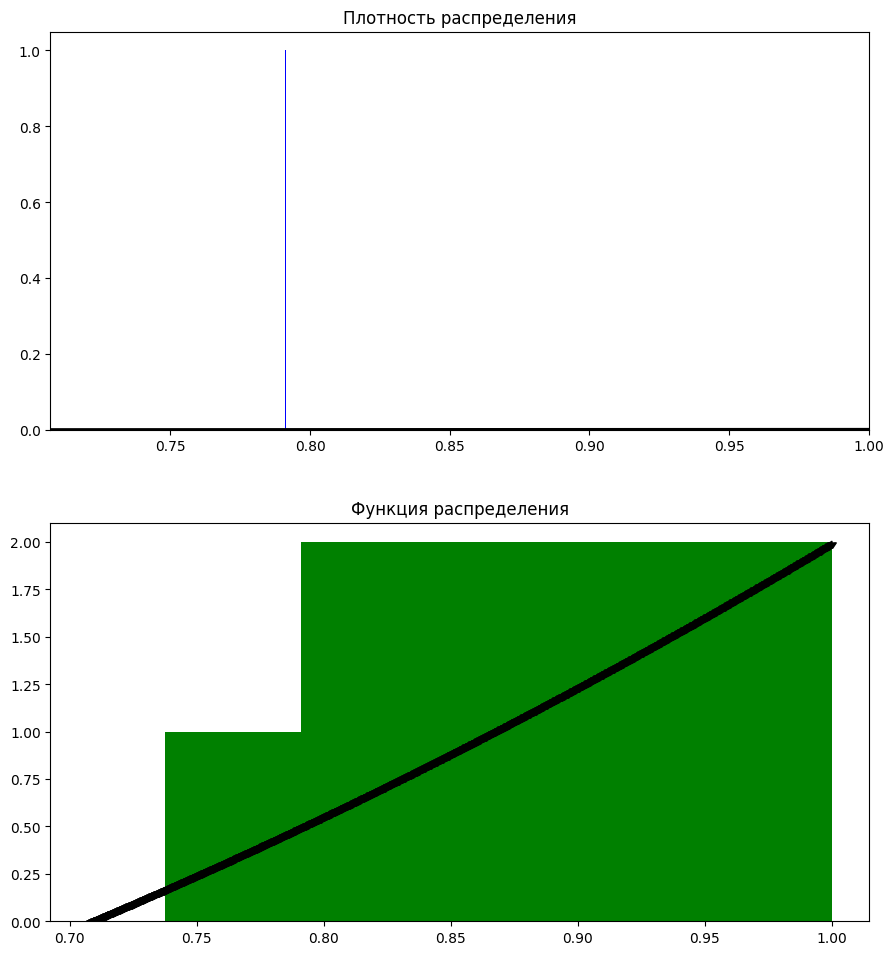

In [91]:
hist, bins = np.histogram(func_data, bins=number_of_dots, range=limits)
plt.subplot(6, 1, 1)  
plt.tight_layout(pad = 5)
plt.hist(x=func_data, color="blue", bins=number_of_dots, range=limits)
plt.xlim(limits)
plt.title("Плотность распределения")
    

# building derivate plot
derivative_expr = diff(ex, x)
    
length = (limits[1] - limits[0]) / number_of_dots # step
dots = np.arange(limits[0] + length / 2, limits[1], length) # Точки для оценки производной
derivative = lambdify(x, length * number_of_tests * derivative_expr)
results = list(map(derivative, dots))
plt.plot(dots, results, marker=11, color="black")
    
# гистограмма накопленных частот
extra_hist = hist.copy()
    
for i in range(1, len(hist)):
    extra_hist[i] += extra_hist[i-1]
        
plt.subplot(6, 1, 2)
ax = plt.gca()
ax.bar(bins[:-1], extra_hist, width = length, align="edge", color='green')

distribution_function = lambdify(x, number_of_tests * ex)
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)
distribution_results = list(map(distribution_function, distribution_dots))
    
plt.plot(distribution_dots, distribution_results, marker=11, color="black")
plt.title("Функция распределения")
plt.show()

In [92]:
delta = get_delta(theoretical_std_deviation)
offset_delta = get_offset_delta(sample_std_deviation)

In [93]:
from IPython.display import HTML, display

val = np.square(offset_delta)

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


data = [['Опиcание', 'Мат ожидание', 'Дисперсия'],
        ['Выборочно', sample_mean, sample_variance],
        ['Теоретическое', theoretical_mean, theoretical_variance],
        ['Доверительный интервал начало', sample_mean-delta,val[0]],
        ['Доверительный интервал конец',sample_mean+delta,val[1]]]

display_table(data)

Спиcание,Мат ожидание,Дисперсия
Выборочно,0.7644583084490714,0.0007210496919668356
Теоретическое,0.861928812542301,0.00707872210941818
Доверительный интервал начало,0.647855093470952,0.000143524288784140
Доверительный интервал конец,0.881061523427191,0.734214811724049


In [94]:
k = number_of_dots - 2 - 1 # число степеней свободы
critical_value = chi2.isf(hypothesis_error_value, k)
normal_value = 0
    
for i in range(number_of_dots):
    normal_value += np.square(hist[i] - results[i]) / results[i]

In [95]:
result_for_print = "принимаем" if normal_value < critical_value else "отвергаем"
data1 = [['Описание', 'Значение'],
         ["Критический хи-квадрат",critical_value],
         ["хи-квадрат выборки",normal_value],
         ["Гипотезу согласия",result_for_print]]

display_table(data1)
    

Описание,Значение
Критический хи-квадрат,1071.568999044425
хи-квадрат выборки,1115.8391949872384
Гипотезу согласия,отвергаем


#### Задание 2. ИМИТАЦИЯ ДИСКРЕТНЫХ СЛУЧАЙНЫХ ВЕЛИЧИН (с заданным законом распределения)

In [96]:
inverse_function = ""
distribution_expression = ""
plt.rcParams["figure.figsize"] = (10, 30)
max_value1 = 40
gamma1 = 0.95
number_of_dots1 = 20
hypothesis_error_value1 = 0.05

In [97]:
# случайное количество попыток до первого успеха в соответствии
# с геометрическим распределением

generator1 = CustomGenerator()


def get_random1():
    random_number = generator1.random()
    
    for i in range(max_value1):
        probability = p_prob1 * (1 - p_prob1) ** i # геометрическое распределение
        
        if random_number < probability:
            return i + 1
        
        random_number -= probability
        
    return max_value1

In [98]:
def get_random_data():
    result = []
    
    for i in range(number_of_tests1):
        result.append(get_random1())
    
    return result

In [99]:
def get_mean(data):
    return sum(data) / number_of_tests1

def get_theoretical_mean():
    return 1 / p_prob1

In [100]:
def get_theoretical_variance():
    return (1 - p_prob1) / np.square(p_prob1)

def get_variance(data, mean):
    result = 0
    
    for item in data:
        result += (item - mean) ** 2
        
    return result / number_of_tests1


In [101]:
def get_delta1(offset):
    t = norm.ppf(gamma1 / 2 + 0.5)
    return t * offset / np.sqrt(number_of_tests1)

def get_offset_delta1(test_offset):
    alphas = ((1 - gamma1) / 2, (1 + gamma1) / 2)
    chis = (chi2.isf(alphas, number_of_tests1 - 1))
    corrected_offset = sqrt((test_offset ** 2) * number_of_tests1 / (number_of_tests1 - 1))
    temp = np.sqrt(number_of_tests1 - 1) * corrected_offset
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))


In [102]:
number_of_tests1 = int(input("Введите количество значений, которые будут сгенерированы:\n"))
p_prob1 = float(input("Введите вероятность:\n"))

In [103]:
data = get_random_data()
mean = get_mean(data)
theor_mean = get_theoretical_mean()
variance = get_variance(data, mean)
teoretical_variance = get_theoretical_variance()
standard_deviation1 = sqrt(variance)
theoretical_standard_deviation1 = sqrt(theoretical_variance)
deltaone = get_delta1(theoretical_standard_deviation1)
offset_delta1 = get_offset_delta1(standard_deviation1)

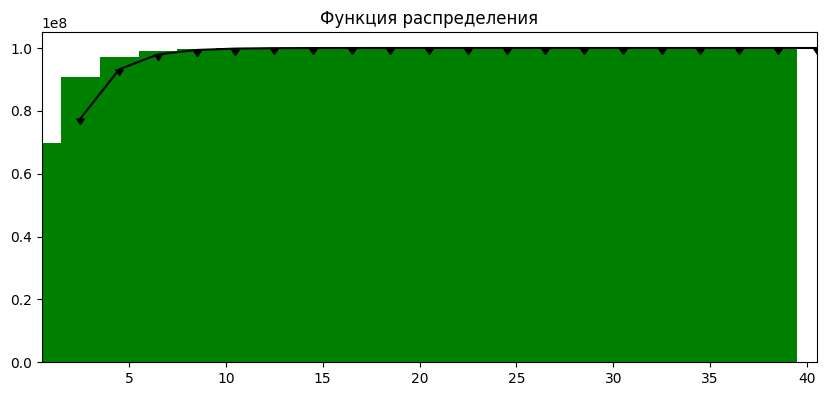

In [104]:
limits = (0.5, max_value1 + 0.5)
hist, bins = np.histogram(data, bins=number_of_dots1, range=limits)

length = max_value1 / number_of_dots1
dots = np.arange(0.5 * (length + 1), max_value1 + length / 2, length)
derivative = lambdify(x, integrate(number_of_tests1 * p_prob1 * ((1 - p_prob1) ** (x - 1)), (x, x - length / 2, x + length / 2)))
results = list(map(derivative, dots))

plt.subplot(6, 1, 2)
        
extra_hist = hist.copy()
    
for i in range(1, len(hist)):
    extra_hist[i] += extra_hist[i-1]
    
ax = plt.gca()
ax.bar(bins[:-1], extra_hist, width = length,  color = "green")
plt.xlim(limits)
    
distribution_function = lambdify(x, number_of_tests1 * (1 - (1 - p_prob1) ** x))
distribution_dots = np.arange(limits[0] + length, limits[1] + length / 10, length)
    
distribution_results = list(map(distribution_function, distribution_dots))
plt.plot(distribution_dots, distribution_results, marker=11, color="black")
plt.title("Функция распределения")
plt.show()

In [105]:
k = number_of_dots1 - 2 - 1
critical_value = chi2.isf(hypothesis_error_value1, k)
normal_value = 0
    
for i in range(number_of_dots1):
    normal_value += np.square(hist[i] - results[i]) / results[i]
    

In [106]:
from IPython.display import HTML, display

val = np.square(offset_delta1)

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))


data = [['Опиcание', 'Математическое ожидание', 'Дисперсия'],
        ['Выборочно', mean, variance],
        ['Теоретическое', theor_mean, teoretical_variance],
        ['Доверительный начало', mean-deltaone,val[0]],
        ['Доверительный конец',mean+deltaone,val[1]]]
display_table(data)

Опиcание,Математическое ожидание,Дисперсия
Выборочно,2.22226323,2.717319125372635
Теоретическое,2.2222222222222223,2.7160493827160495
Доверительный начало,2.22224673981520,2.71656612120801
Доверительный конец,2.22227972018480,2.71807249847376


In [107]:
result_for_print = "принимаем" if normal_value < critical_value else "отвергаем"
data1 = [['Описание', 'Значение'],
         ["Критический кси-квадрат",critical_value],
         ["Кси-квадрат выборки",normal_value],
         ["Гипотезу согласия",result_for_print]]

display_table(data1)
    

Описание,Значение
Критический кси-квадрат,27.587111638275335
Кси-квадрат выборки,22060.692218627337
Гипотезу согласия,отвергаем
